In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import MobileViTForImageClassification, MobileViTFeatureExtractor
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Datasets
train_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/trainset', transform=train_transform)
test_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/testset', transform=test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model and feature extractor
feature_extractor = MobileViTFeatureExtractor.from_pretrained('apple/mobilevit-small')
model = MobileViTForImageClassification.from_pretrained('apple/mobilevit-small', num_labels=len(train_dataset.classes), ignore_mismatched_sizes=True).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training settings
num_epochs = 10
train_losses = []
val_losses = []  # Initialize the validation losses list
train_accuracies = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for images, labels in train_loader:
        images = [feature_extractor(images[i].cpu().detach().numpy(), return_tensors="pt") for i in range(len(images))]
        inputs = torch.stack([img['pixel_values'].squeeze() for img in images]).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(pixel_values=inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_preds / total_preds
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = [feature_extractor(images[i].cpu().detach().numpy(), return_tensors="pt") for i in range(len(images))]
            inputs = torch.stack([img['pixel_values'].squeeze() for img in images]).to(device)
            labels = labels.to(device)
            
            outputs = model(pixel_values=inputs)
            loss = criterion(outputs.logits, labels)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            all_targets.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Compute the validation loss for the epoch
    val_loss = val_running_loss / len(test_loader)
    val_losses.append(val_loss)

    val_accuracy = 100 * val_correct / val_total
    val_prec = precision_score(all_targets, all_predictions, average='macro', zero_division=0)
    val_recall = recall_score(all_targets, all_predictions, average='macro', zero_division=0)
    val_f1 = f1_score(all_targets, all_predictions, average='macro')
    
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_prec)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)
    
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, '
          f'F1 Score: {val_f1:.2f}, Precision: {val_prec:.2f}, Recall: {val_recall:.2f}')

# Save the model's state dict
torch.save(model.state_dict(), 'mobilevit_finetuned.pth')

# Plotting accuracy and loss in a single plot
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')

# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='green')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red') 

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Print the highest values for accuracy, F1 score, precision, and recall
print(f'Highest Validation Accuracy: {max(val_accuracies):.2f}%')
print(f'Highest F1 Score: {max(val_f1_scores):.2f}')
print(f'Highest Precision: {max(val_precisions):.2f}')
print(f'Highest Recall: {max(val_recalls):.2f}')


In [ ]:
import torch
from torchvision import datasets, transforms
from transformers import MobileViTForImageClassification, MobileViTFeatureExtractor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Load the test dataset
test_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/testset', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model and feature extractor
feature_extractor = MobileViTFeatureExtractor.from_pretrained('apple/mobilevit-small')
model = MobileViTForImageClassification.from_pretrained('apple/mobilevit-small', num_labels=len(test_dataset.classes),ignore_mismatched_sizes=True).to(device)

# Load the trained model's weights
model.load_state_dict(torch.load('mobilevit_finetuned.pth'))
model.eval()

# Lists to store true labels and predictions
all_labels = []
all_preds = []

# Evaluate the model on the test set
with torch.no_grad():
    for images, labels in test_loader:
        images = [feature_extractor(images[i].cpu().detach().numpy(), return_tensors="pt") for i in range(len(images))]
        inputs = torch.stack([img['pixel_values'].squeeze() for img in images]).to(device)

        outputs = model(pixel_values=inputs)
        _, preds = torch.max(outputs.logits, 1)

        # Extend the lists with labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Create confusion matrix
class_names = test_dataset.classes
cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Normalized Confusion Matrix')
plt.show()


2024-05-15 17:14:44.440113: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 17:14:44.440201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 17:14:44.574762: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/mobilevit/feature_extraction_mobilevit.py:28: FutureWarning: The class MobileViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MobileViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([10, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
It looks like you are trying to rescale already rescaled images. If the inp

Epoch 1/10, Train Loss: 1.5282, Train Accuracy: 0.6320, Validation Loss: 0.6528, Validation Accuracy: 0.8190, F1 Score: 0.8003, Precision: 0.8496, Recall: 0.8190
Epoch 2/10, Train Loss: 0.4762, Train Accuracy: 0.8792, Validation Loss: 0.2786, Validation Accuracy: 0.8970, F1 Score: 0.8941, Precision: 0.9066, Recall: 0.8970
Epoch 3/10, Train Loss: 0.2438, Train Accuracy: 0.9305, Validation Loss: 0.1362, Validation Accuracy: 0.9490, F1 Score: 0.9487, Precision: 0.9504, Recall: 0.9490
Epoch 4/10, Train Loss: 0.1335, Train Accuracy: 0.9675, Validation Loss: 0.1553, Validation Accuracy: 0.9510, F1 Score: 0.9507, Precision: 0.9586, Recall: 0.9510
Epoch 5/10, Train Loss: 0.1153, Train Accuracy: 0.9673, Validation Loss: 0.0673, Validation Accuracy: 0.9790, F1 Score: 0.9789, Precision: 0.9814, Recall: 0.9790
Epoch 6/10, Train Loss: 0.0815, Train Accuracy: 0.9830, Validation Loss: 0.0412, Validation Accuracy: 0.9880, F1 Score: 0.9880, Precision: 0.9883, Recall: 0.9880
Epoch 7/10, Train Loss: 0.06

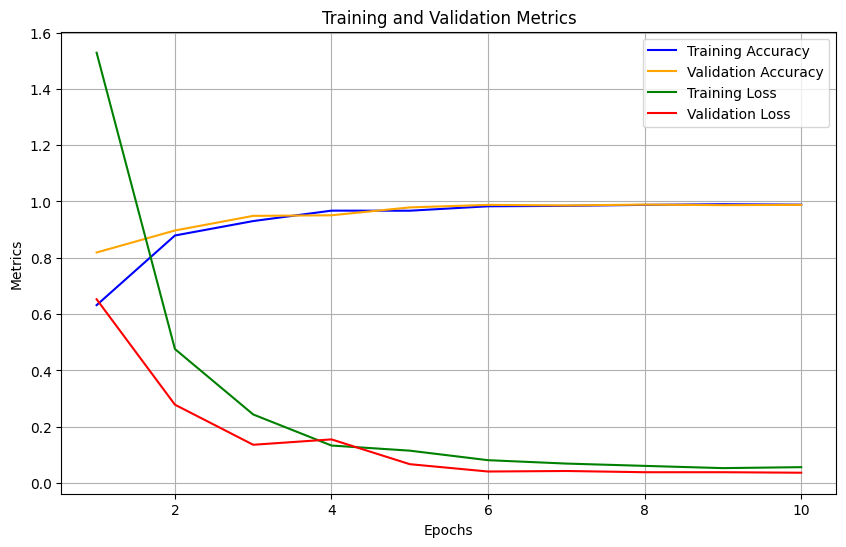

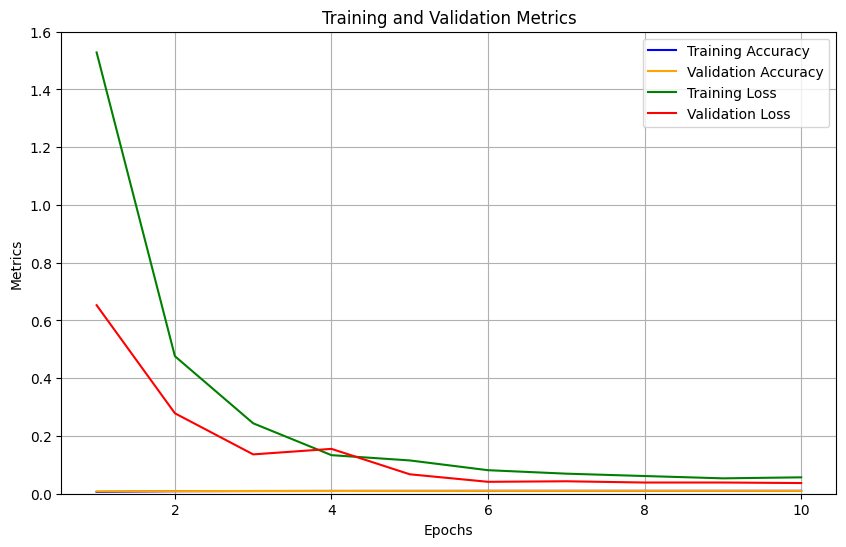

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import MobileViTForImageClassification, MobileViTFeatureExtractor
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Datasets
train_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/trainset', transform=train_transform)
test_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/testset', transform=test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model and feature extractor
feature_extractor = MobileViTFeatureExtractor.from_pretrained('apple/mobilevit-small')
model = MobileViTForImageClassification.from_pretrained('apple/mobilevit-small', num_labels=len(train_dataset.classes), ignore_mismatched_sizes=True).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Implement a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training settings
num_epochs = 10
train_losses = []
val_losses = []  # Initialize the validation losses list
train_accuracies = []
val_accuracies = []
val_f1_scores = []
val_precisions = []
val_recalls = []

# Training and validation loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for images, labels in train_loader:
        images = [feature_extractor(images[i].cpu().detach().numpy(), return_tensors="pt") for i in range(len(images))]
        inputs = torch.stack([img['pixel_values'].squeeze() for img in images]).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(pixel_values=inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_preds / total_preds
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = [feature_extractor(images[i].cpu().detach().numpy(), return_tensors="pt") for i in range(len(images))]
            inputs = torch.stack([img['pixel_values'].squeeze() for img in images]).to(device)
            labels = labels.to(device)
            
            outputs = model(pixel_values=inputs)
            loss = criterion(outputs.logits, labels)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
            all_targets.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    val_loss = val_running_loss / len(test_loader)
    val_accuracy = val_correct / val_total
    val_prec = precision_score(all_targets, all_predictions, average='macro', zero_division=0)
    val_recall = recall_score(all_targets, all_predictions, average='macro', zero_division=0)
    val_f1 = f1_score(all_targets, all_predictions, average='macro')
    
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_prec)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)
    
    # Update the learning rate
    scheduler.step()
    
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, '
          f'F1 Score: {val_f1:.4f}, Precision: {val_prec:.4f}, Recall: {val_recall:.4f}')

# Save the model's state dict
torch.save(model.state_dict(), 'mobilevit_finetuned.pth')

# Plotting accuracy and loss in a single plot
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')

# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='green')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plotting accuracy and loss in a single plot
plt.figure(figsize=(10, 6))

# Convert accuracy to a decimal instead of percentage for the plot
train_accuracies_decimal = [acc / 100 for acc in train_accuracies]
val_accuracies_decimal = [acc / 100 for acc in val_accuracies]

# Plot training and validation accuracy as decimals
plt.plot(range(1, num_epochs + 1), train_accuracies_decimal, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies_decimal, label='Validation Accuracy', color='orange')

# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='green')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')

# Adjust y-axis limits to match the new scale of accuracy
plt.ylim(0, 1.6)

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend(loc='best')
plt.grid(True)
plt.show()


/opt/conda/lib/python3.10/site-packages/transformers/models/mobilevit/feature_extraction_mobilevit.py:28: FutureWarning: The class MobileViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MobileViTImageProcessor instead.
  warnings.warn(
Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([10, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


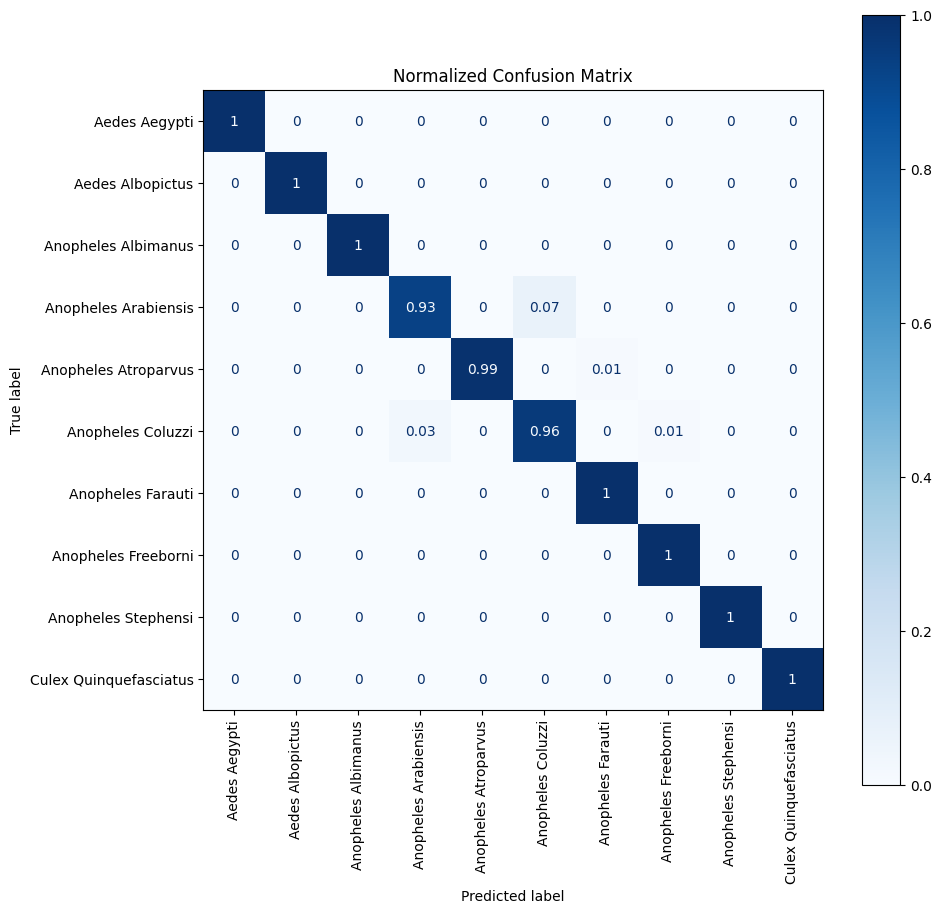

In [2]:
import torch
from torchvision import datasets, transforms
from transformers import MobileViTForImageClassification, MobileViTFeatureExtractor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Load the test dataset
test_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/testset', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model and feature extractor
feature_extractor = MobileViTFeatureExtractor.from_pretrained('apple/mobilevit-small')
model = MobileViTForImageClassification.from_pretrained('apple/mobilevit-small', num_labels=len(test_dataset.classes),ignore_mismatched_sizes=True).to(device)

# Load the trained model's weights
model.load_state_dict(torch.load('mobilevit_finetuned.pth'))
model.eval()

# Lists to store true labels and predictions
all_labels = []
all_preds = []

# Evaluate the model on the test set
with torch.no_grad():
    for images, labels in test_loader:
        images = [feature_extractor(images[i].cpu().detach().numpy(), return_tensors="pt") for i in range(len(images))]
        inputs = torch.stack([img['pixel_values'].squeeze() for img in images]).to(device)

        outputs = model(pixel_values=inputs)
        _, preds = torch.max(outputs.logits, 1)

        # Extend the lists with labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Create confusion matrix
class_names = test_dataset.classes
cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Normalized Confusion Matrix')
plt.show()


In [7]:
import torch
from torchvision import datasets, transforms
from transformers import MobileViTForImageClassification, MobileViTFeatureExtractor
from sklearn.metrics import accuracy_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations for the test set
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

# Load the test dataset
test_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/testset', transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model and feature extractor
feature_extractor = MobileViTFeatureExtractor.from_pretrained('apple/mobilevit-small')
model = MobileViTForImageClassification.from_pretrained('apple/mobilevit-small', num_labels=len(test_dataset.classes), ignore_mismatched_sizes=True).to(device)

# Load the trained model's weights
model.load_state_dict(torch.load('/kaggle/working/mobilevit_finetuned.pth', map_location=device))
model.eval()

# Lists to store true labels and predictions
all_labels = []
all_preds = []

# Evaluate the model on the test set
with torch.no_grad():
    for images, labels in test_loader:
        images = [feature_extractor(images[i].cpu().detach().numpy(), return_tensors="pt") for i in range(len(images))]
        inputs = torch.stack([img['pixel_values'].squeeze() for img in images]).to(device)

        outputs = model(pixel_values=inputs)
        _, preds = torch.max(outputs.logits, 1)

        # Extend the lists with labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {test_accuracy:.4f}')


/opt/conda/lib/python3.10/site-packages/transformers/models/mobilevit/feature_extraction_mobilevit.py:28: FutureWarning: The class MobileViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MobileViTImageProcessor instead.
  warnings.warn(
Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([10, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy: 0.9880


In [13]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances
import pickle

from transformers import MobileViTForImageClassification

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the MobileViT model
model = MobileViTForImageClassification.from_pretrained('apple/mobilevit-small', num_labels=10, ignore_mismatched_sizes=True).to(device)

# Load the trained model's weights (replace the path with your model's path)
model.load_state_dict(torch.load('/kaggle/working/mobilevit_finetuned.pth', map_location=device))
model.eval()  # Set the model to evaluation mode

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset (replace the root path with your dataset's path)
dataset = ImageFolder(root='/kaggle/input/datasetmosquito/dataset/dataset/trainset', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Extract logits and labels from the training data
logits = []
labels = []
with torch.no_grad():
    for images, label in dataloader:
        images = images.to(device)
        outputs = model(images)
        logits_tensor = outputs.logits  # Accessing the logits directly
        logits.append(logits_tensor.cpu().numpy().flatten())  # Now you use .cpu() on the tensor
        labels.append(label.item())

logits = np.array(logits)
labels = np.array(labels)

# Calculate MAVs and distances for each class
mavs = []
distances = []
for i in range(10):  # Assuming there are 10 classes
    class_indices = np.where(labels == i)[0]
    class_logits = logits[class_indices]
    mav = np.mean(class_logits, axis=0)
    mavs.append(mav)
    dist = euclidean_distances([mav], class_logits)
    distances.append(dist.flatten())

# Fit Weibull distribution for each class
weibull_models = []
for dist in distances:
    params = weibull_min.fit(dist, floc=0)
    weibull_models.append(params)

# Save the MAVs and Weibull models
with open('/kaggle/working/MobileVit_mavs_and_weibull.pkl', 'wb') as f:
    pickle.dump((mavs, weibull_models), f)

print("MAVs and Weibull models are ready for prediction.")


Using device: cuda


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([10, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MAVs and Weibull models are ready for prediction.


In [21]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances
import pickle

from transformers import MobileViTForImageClassification

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the MobileViT model
model = MobileViTForImageClassification.from_pretrained('apple/mobilevit-small', num_labels=10, ignore_mismatched_sizes=True).to(device)

# Load the trained model's weights (replace the path with your model's path)
model.load_state_dict(torch.load('/kaggle/working/mobilevit_finetuned.pth', map_location=device))
model.eval()  # Set the model to evaluation mode

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset (replace the root path with your dataset's path)
dataset = ImageFolder(root='/kaggle/input/datasetmosquito/dataset/dataset/trainset', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Extract logits and labels from the training data
logits = []
labels = []
with torch.no_grad():
    for images, label in dataloader:
        images = images.to(device)
        outputs = model(images)
        
        # Ensure outputs.logits is the correct shape
        logits_tensor = outputs.logits
        if logits_tensor.dim() != 2 or logits_tensor.size(1) != 10:
            raise ValueError(f"Unexpected logits shape: {logits_tensor.shape}")
        
        logits.append(logits_tensor.cpu().numpy().flatten())  # Now you use .cpu() on the tensor
        labels.append(label.item())

logits = np.array(logits)
labels = np.array(labels)

# Calculate MAVs and distances for each class
mavs = []
distances = []
for i in range(10):  # Assuming there are 10 classes
    class_indices = np.where(labels == i)[0]
    class_logits = logits[class_indices]
    mav = np.mean(class_logits, axis=0)
    mavs.append(mav)
    dist = euclidean_distances([mav], class_logits)
    distances.append(dist.flatten())

# Fit Weibull distribution for each class
weibull_models = []
for dist in distances:
    params = weibull_min.fit(dist, floc=0)
    weibull_models.append(params)

# Save the MAVs and Weibull models
with open('/kaggle/working/MobileVit_mavs_and_weibull.pkl', 'wb') as f:
    pickle.dump((mavs, weibull_models), f)

print("MAVs and Weibull models are ready for prediction.")


Using device: cuda


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([10, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MAVs and Weibull models are ready for prediction.


In [22]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, accuracy_score, classification_report
import pickle
from transformers import MobileViTForImageClassification

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the MobileViT model
model = MobileViTForImageClassification.from_pretrained('apple/mobilevit-small', num_labels=10, ignore_mismatched_sizes=True)
model_path = '/kaggle/working/mobilevit_finetuned.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/kaggle/input/datasetmosquito/openmaxTestset/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/kaggle/working/MobileVit_mavs_and_weibull.pkl', 'rb') as f:  # Ensure correct file name
    mavs, weibull_models = pickle.load(f)

# Define class names including 'Unknown'
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']

# Classify images using OpenMax
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).logits.cpu().numpy().flatten()

        recalibrated_scores = np.zeros(len(mavs))  # Placeholder for recalibrated scores
        threshold = 0.5  # Threshold to decide 'unknown'
        for j in range(len(mavs)):
            dist = euclidean_distances([outputs], [mavs[j]])[0][0]
            shape, loc, scale = weibull_models[j]
            weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
            recalibrated_scores[j] = 1 - weibull_cdf

        if max(recalibrated_scores) < threshold:
            predictions.append(10)  # Index for 'Unknown'
        else:
            predictions.append(np.argmax(recalibrated_scores))

        true_labels.append(labels.item())

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Using device: cuda


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([10, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.3181818181818182
Classification Report:
                         precision    recall  f1-score   support

         Aedes Aegypti       0.21      0.27      0.24       100
      Aedes Albopictus       0.18      0.22      0.20       100
   Anopheles Albimanus       0.21      0.14      0.17       100
  Anopheles Arabiensis       0.26      0.35      0.30       100
  Anopheles Atroparvus       0.36      0.13      0.19       100
     Anopheles Coluzzi       0.13      0.07      0.09       100
     Anopheles Farauti       0.34      0.33      0.34       100
   Anopheles Freeborni       0.38      0.25      0.30       100
   Anopheles Stephensi       0.79      0.57      0.66       100
Culex Quinquefasciatus       0.28      0.34      0.30       100
               Unknown       0.41      0.83      0.55       100

              accuracy                           0.32      1100
             macro avg       0.32      0.32      0.30      1100
          weighted avg       0.32      0.32      

In [23]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, accuracy_score, classification_report
import pickle
from transformers import MobileViTForImageClassification

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the MobileViT model
model = MobileViTForImageClassification.from_pretrained('apple/mobilevit-small', num_labels=10, ignore_mismatched_sizes=True)
model_path = '/kaggle/working/mobilevit_finetuned.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/kaggle/input/datasetmosquito/openmaxTestset/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/kaggle/working/MobileVit_mavs_and_weibull.pkl', 'rb') as f:  # Ensure correct file name
    mavs, weibull_models = pickle.load(f)

# Define class names including 'Unknown'
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']

# Classify images using OpenMax
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).logits.cpu().numpy().flatten()

        recalibrated_scores = np.zeros(len(mavs))  # Placeholder for recalibrated scores
        threshold = 0.4  # Threshold to decide 'unknown'
        for j in range(len(mavs)):
            dist = euclidean_distances([outputs], [mavs[j]])[0][0]
            shape, loc, scale = weibull_models[j]
            weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
            recalibrated_scores[j] = 1 - weibull_cdf

        if max(recalibrated_scores) < threshold:
            predictions.append(10)  # Index for 'Unknown'
        else:
            predictions.append(np.argmax(recalibrated_scores))

        true_labels.append(labels.item())

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Using device: cuda


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([10, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.3336363636363636
Classification Report:
                         precision    recall  f1-score   support

         Aedes Aegypti       0.21      0.27      0.24       100
      Aedes Albopictus       0.18      0.23      0.20       100
   Anopheles Albimanus       0.21      0.14      0.17       100
  Anopheles Arabiensis       0.24      0.38      0.29       100
  Anopheles Atroparvus       0.36      0.13      0.19       100
     Anopheles Coluzzi       0.13      0.07      0.09       100
     Anopheles Farauti       0.34      0.33      0.34       100
   Anopheles Freeborni       0.38      0.25      0.30       100
   Anopheles Stephensi       0.78      0.69      0.73       100
Culex Quinquefasciatus       0.29      0.39      0.33       100
               Unknown       0.54      0.79      0.64       100

              accuracy                           0.33      1100
             macro avg       0.33      0.33      0.32      1100
          weighted avg       0.33      0.33      

In [25]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, accuracy_score, classification_report
import pickle
from transformers import MobileViTForImageClassification

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the MobileViT model
model = MobileViTForImageClassification.from_pretrained('apple/mobilevit-small', num_labels=10, ignore_mismatched_sizes=True)
model_path = '/kaggle/working/mobilevit_finetuned.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/kaggle/input/datasetmosquito/openmaxTestset/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/kaggle/working/MobileVit_mavs_and_weibull.pkl', 'rb') as f:  # Ensure correct file name
    mavs, weibull_models = pickle.load(f)

# Define class names including 'Unknown'
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']

# Classify images using OpenMax
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).logits.cpu().numpy().flatten()

        recalibrated_scores = np.zeros(len(mavs))  # Placeholder for recalibrated scores
        threshold = 0.3  # Threshold to decide 'unknown'
        for j in range(len(mavs)):
            dist = euclidean_distances([outputs], [mavs[j]])[0][0]
            shape, loc, scale = weibull_models[j]
            weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
            recalibrated_scores[j] = 1 - weibull_cdf

        if max(recalibrated_scores) < threshold:
            predictions.append(10)  # Index for 'Unknown'
        else:
            predictions.append(np.argmax(recalibrated_scores))

        true_labels.append(labels.item())

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Using device: cuda


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([10, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.33090909090909093
Classification Report:
                         precision    recall  f1-score   support

         Aedes Aegypti       0.21      0.27      0.24       100
      Aedes Albopictus       0.18      0.23      0.20       100
   Anopheles Albimanus       0.20      0.14      0.17       100
  Anopheles Arabiensis       0.22      0.38      0.28       100
  Anopheles Atroparvus       0.36      0.13      0.19       100
     Anopheles Coluzzi       0.13      0.07      0.09       100
     Anopheles Farauti       0.34      0.33      0.34       100
   Anopheles Freeborni       0.38      0.25      0.30       100
   Anopheles Stephensi       0.73      0.72      0.72       100
Culex Quinquefasciatus       0.31      0.44      0.36       100
               Unknown       0.63      0.68      0.65       100

              accuracy                           0.33      1100
             macro avg       0.34      0.33      0.32      1100
          weighted avg       0.34      0.33     

In [26]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, accuracy_score, classification_report
import pickle
from transformers import MobileViTForImageClassification

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the MobileViT model
model = MobileViTForImageClassification.from_pretrained('apple/mobilevit-small', num_labels=10, ignore_mismatched_sizes=True)
model_path = '/kaggle/working/mobilevit_finetuned.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/kaggle/input/datasetmosquito/openmaxTestset/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/kaggle/working/MobileVit_mavs_and_weibull.pkl', 'rb') as f:  # Ensure correct file name
    mavs, weibull_models = pickle.load(f)

# Define class names including 'Unknown'
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']

# Classify images using OpenMax
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).logits.cpu().numpy().flatten()

        recalibrated_scores = np.zeros(len(mavs))  # Placeholder for recalibrated scores
        threshold = 0.2  # Threshold to decide 'unknown'
        for j in range(len(mavs)):
            dist = euclidean_distances([outputs], [mavs[j]])[0][0]
            shape, loc, scale = weibull_models[j]
            weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
            recalibrated_scores[j] = 1 - weibull_cdf

        if max(recalibrated_scores) < threshold:
            predictions.append(10)  # Index for 'Unknown'
        else:
            predictions.append(np.argmax(recalibrated_scores))

        true_labels.append(labels.item())

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Using device: cuda


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([10, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.3390909090909091
Classification Report:
                         precision    recall  f1-score   support

         Aedes Aegypti       0.21      0.27      0.24       100
      Aedes Albopictus       0.19      0.24      0.21       100
   Anopheles Albimanus       0.20      0.14      0.17       100
  Anopheles Arabiensis       0.21      0.38      0.27       100
  Anopheles Atroparvus       0.36      0.13      0.19       100
     Anopheles Coluzzi       0.13      0.07      0.09       100
     Anopheles Farauti       0.34      0.33      0.34       100
   Anopheles Freeborni       0.38      0.25      0.30       100
   Anopheles Stephensi       0.71      0.74      0.73       100
Culex Quinquefasciatus       0.34      0.54      0.42       100
               Unknown       0.75      0.64      0.69       100

              accuracy                           0.34      1100
             macro avg       0.35      0.34      0.33      1100
          weighted avg       0.35      0.34      

In [24]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, accuracy_score, classification_report
import pickle
from transformers import MobileViTForImageClassification

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the MobileViT model
model = MobileViTForImageClassification.from_pretrained('apple/mobilevit-small', num_labels=10, ignore_mismatched_sizes=True)
model_path = '/kaggle/working/mobilevit_finetuned.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to match model expected input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/kaggle/input/datasetmosquito/openmaxTestset/openmaxTestset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/kaggle/working/MobileVit_mavs_and_weibull.pkl', 'rb') as f:  # Ensure correct file name
    mavs, weibull_models = pickle.load(f)

# Define class names including 'Unknown'
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']

# Classify images using OpenMax
predictions = []
true_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).logits.cpu().numpy().flatten()

        recalibrated_scores = np.zeros(len(mavs))  # Placeholder for recalibrated scores
        threshold = 0.1  # Threshold to decide 'unknown'
        for j in range(len(mavs)):
            dist = euclidean_distances([outputs], [mavs[j]])[0][0]
            shape, loc, scale = weibull_models[j]
            weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
            recalibrated_scores[j] = 1 - weibull_cdf

        if max(recalibrated_scores) < threshold:
            predictions.append(10)  # Index for 'Unknown'
        else:
            predictions.append(np.argmax(recalibrated_scores))

        true_labels.append(labels.item())

# Calculate accuracy and classification report
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=class_names)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Using device: cuda


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([10, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 0.34454545454545454
Classification Report:
                         precision    recall  f1-score   support

         Aedes Aegypti       0.21      0.27      0.24       100
      Aedes Albopictus       0.18      0.24      0.21       100
   Anopheles Albimanus       0.20      0.14      0.17       100
  Anopheles Arabiensis       0.21      0.38      0.27       100
  Anopheles Atroparvus       0.36      0.13      0.19       100
     Anopheles Coluzzi       0.13      0.07      0.09       100
     Anopheles Farauti       0.34      0.33      0.34       100
   Anopheles Freeborni       0.38      0.25      0.30       100
   Anopheles Stephensi       0.72      0.79      0.75       100
Culex Quinquefasciatus       0.37      0.61      0.46       100
               Unknown       0.89      0.58      0.70       100

              accuracy                           0.34      1100
             macro avg       0.36      0.34      0.34      1100
          weighted avg       0.36      0.34     

Using device: cuda


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([10, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


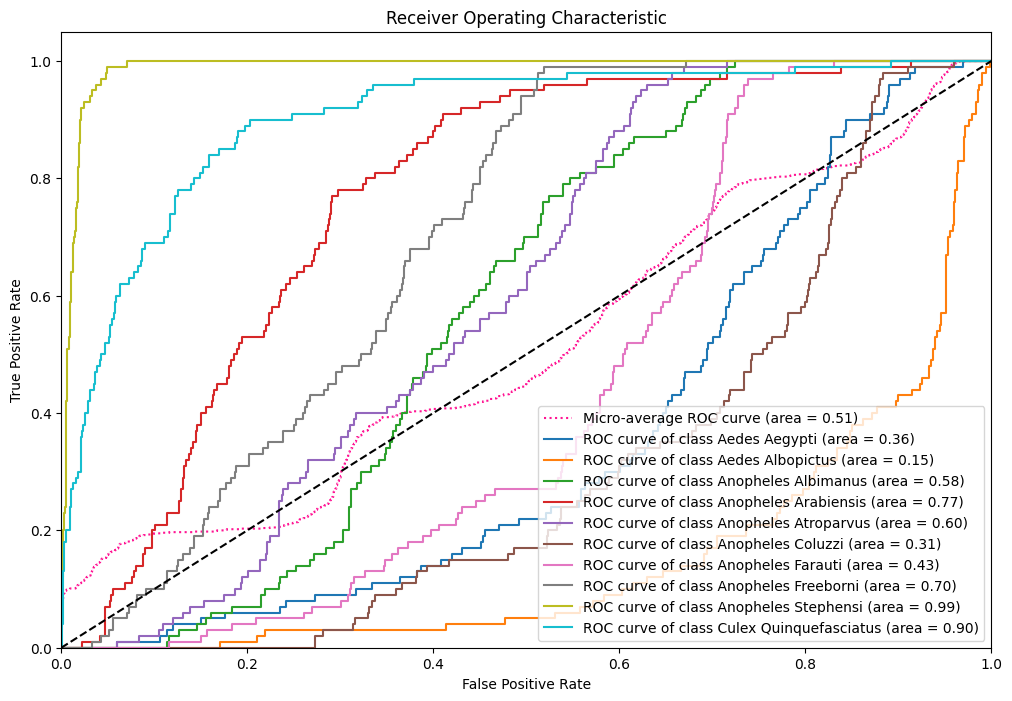

AUROC per class:
Aedes Aegypti: 0.36
Aedes Albopictus: 0.15
Anopheles Albimanus: 0.58
Anopheles Arabiensis: 0.77
Anopheles Atroparvus: 0.60
Anopheles Coluzzi: 0.31
Anopheles Farauti: 0.43
Anopheles Freeborni: 0.70
Anopheles Stephensi: 0.99
Culex Quinquefasciatus: 0.90
Micro-average AUROC: 0.5137772222222222


In [28]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from transformers import MobileViTForImageClassification

# Setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the MobileViT model with ignore_mismatched_sizes
model = MobileViTForImageClassification.from_pretrained(
    'apple/mobilevit-small', 
    num_labels=10, 
    ignore_mismatched_sizes=True
).to(device)

# Load the trained model's weights (replace the path with your model's path)
model_path = '/kaggle/working/mobilevit_finetuned.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set the model to evaluation mode

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/kaggle/input/datasetmosquito/dataset/dataset/testset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Prepare label binarizer
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus']
n_classes = len(class_names)

# Collect all scores and true labels
true_labels = []
scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images).logits.cpu().numpy()
        scores.extend(outputs)
        true_labels.extend(labels.numpy())

# Binarize the labels for ROC calculation
true_labels = label_binarize(true_labels, classes=range(n_classes))
scores = np.array(scores)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels.ravel(), scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting ROC curves
plt.figure(figsize=(12, 8))
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print AUROC scores
print("AUROC per class:")
for i, name in enumerate(class_names):
    print(f"{name}: {roc_auc[i]:.2f}")
print("Micro-average AUROC:", roc_auc["micro"])


Using device: cuda


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([10, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


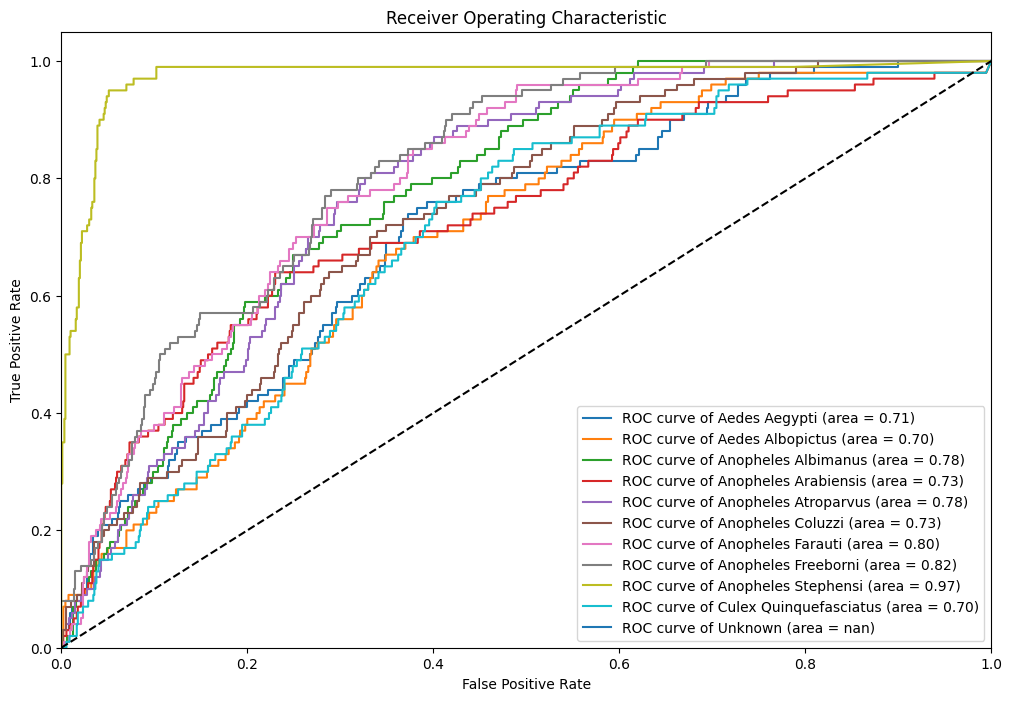

AUROC per class:
Aedes Aegypti: 0.71
Aedes Albopictus: 0.70
Anopheles Albimanus: 0.78
Anopheles Arabiensis: 0.73
Anopheles Atroparvus: 0.78
Anopheles Coluzzi: 0.73
Anopheles Farauti: 0.80
Anopheles Freeborni: 0.82
Anopheles Stephensi: 0.97
Culex Quinquefasciatus: 0.70
Unknown: nan


In [29]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
from scipy.stats import weibull_min
from sklearn.metrics import euclidean_distances, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import pickle
from transformers import MobileViTForImageClassification

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

# Load the MobileViT model
model = MobileViTForImageClassification.from_pretrained(
    'apple/mobilevit-small', 
    num_labels=10, 
    ignore_mismatched_sizes=True
).to(device)

# Load the trained model's weights
model_path = '/kaggle/working/mobilevit_finetuned.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test data using ImageFolder
test_dataset = ImageFolder(root='/kaggle/input/datasetmosquito/dataset/dataset/testset', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load OpenMax parameters
with open('/kaggle/working/MobileVit_mavs_and_weibull.pkl', 'rb') as f:
    mavs, weibull_models = pickle.load(f)

# Prepare for ROC
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus', 'Anopheles Arabiensis',
               'Anopheles Atroparvus', 'Anopheles Coluzzi', 'Anopheles Farauti', 'Anopheles Freeborni',
               'Anopheles Stephensi', 'Culex Quinquefasciatus', 'Unknown']
n_classes = len(class_names) - 1  # excluding the 'Unknown' for initial setup

true_labels = []
scores = []

# Adjust logits using OpenMax
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images).logits.cpu().numpy()
        adjusted_scores = np.zeros((logits.shape[0], n_classes + 1))  # +1 for unknown

        for i, logit in enumerate(logits):
            recalibrated_scores = np.zeros(n_classes)
            for j in range(n_classes):
                dist = euclidean_distances([logit], [mavs[j]])[0][0]
                shape, loc, scale = weibull_models[j]
                weibull_cdf = weibull_min.cdf(dist, shape, loc, scale)
                recalibrated_scores[j] = 1 - weibull_cdf

            if max(recalibrated_scores) < 0.1:  # Threshold for 'Unknown'
                adjusted_scores[i, -1] = 1  # Set last class (Unknown) score to 1
            else:
                adjusted_scores[i, :-1] = recalibrated_scores

            scores.append(adjusted_scores[i])
            true_labels.append(labels.numpy()[i])

scores = np.array(scores)
true_labels = label_binarize(true_labels, classes=range(n_classes + 1))

# Compute ROC and AUROC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes + 1):  # Including 'Unknown'
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
plt.figure(figsize=(12, 8))
for i in range(n_classes + 1):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print AUROC
print("AUROC per class:")
for i in range(n_classes + 1):
    print(f"{class_names[i]}: {roc_auc[i]:.2f}")
